<a href="https://colab.research.google.com/github/kermityan/EPAM-DS-ML-Course-Notebooks/blob/main/NLP_Toxicity_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilingual toxic comment classification using different embeddings

In [ ]:
import os
import gc
import numpy as np
import pandas as pd
import math
import re
import matplotlib.pyplot as plt
import glob
import pickle

In [ ]:
import string
import re
from collections import Counter
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from gensim import utils
import gensim.parsing.preprocessing as gsp
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.decomposition import PCA


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
FILE_PATH = "/content/drive/MyDrive/ds_data/toxicity_data/"
MODEL_PATH = FILE_PATH + 'models/'

Mounted at /content/drive


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


Auxiliary functions:

In [ ]:
def save_sklearn_model(model, filename):
  ''' Saving sklearn model to Google drive'''
  save_path = MODEL_PATH + filename
  pickle.dump(model, open(save_path, 'wb'))

In [ ]:
def load_sklearn_model(filename):
  # load the model from disk
  load_path = MODEL_PATH + filename
  loaded_model = pickle.load(open(load_path, 'rb'))
  return loaded_model

In [ ]:
def model_save(model, name):
  # Saves models parameters

  # Create model save path
  MODEL_NAME = name
  MODEL_SAVE_PATH = MODEL_PATH + MODEL_NAME

  # Save the model state dict
  print(f"Saving model to: {MODEL_SAVE_PATH}")
  torch.save(obj=model.state_dict(),
            f=MODEL_SAVE_PATH)

In [ ]:
def load_model(model_cls, name):
  # Loads model's parameters

  loaded_model_1 = model_cls

  MODEL_SAVE_PATH = MODEL_PATH + name

  # Load model state dict
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

  # Put model to target device
  loaded_model_1.to(device)

  print(f"Loaded model:\n{loaded_model_1}")
  print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")
  return loaded_model_1

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_pred, y_true, labels):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    _, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [ ]:
def classifier_f(clf, X_train, y_train, X_test):
  # Fit classifier, then predict labels and probs
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  probs = clf.predict_proba(X_test)
  return y_pred, probs

In [ ]:
def remove_spec_symbols(text):
  text=''.join(text)
  unicode_pattern = re.compile('[^\u0000-\u007F]+')
  return unicode_pattern.sub(r' ', text)

In [ ]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s):
  if isinstance(s, float) and math.isnan(s):
    return ''
  else:
    result = re_tok.sub(r' \1 ', s).split()

  return result

In [ ]:
filters = [
           gsp.strip_tags, #remove tags
           gsp.strip_punctuation, #remove punctuation
           gsp.strip_multiple_whitespaces, #standarized the spaces
           gsp.strip_numeric,
           gsp.remove_stopwords, #stop words
           gsp.strip_short,
           gsp.stem_text #stemming
          ]

def clean_text(s):
    s = str(s).lower() #lower case for all words
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [ ]:
def get_corpus_statistics(col, top_num=20, verbose=1):
  # Calculating the total number of words in the corpus and frequency of use for every word
  corpus = ""
  for text in col:
    if type(text)==list:
      text = ' '.join(text)
    try:
      corpus += text
    except:
      print(text)
    corpus += ' '
  #words = remove_punct(corpus).lower().split()
  word_counts = Counter(corpus.split())

  result = {}
  if verbose!=0:
    print('Size of vocabulary: ',len(list(word_counts)))
    print(f'Most {top_num} common words are:')
  for item in word_counts.most_common(top_num):
    result[item[0]] = int(item[1])
  return result

In [ ]:
needed_cols = ['toxic', 'comment_text']

Loading and briefly examining the data:

In [ ]:
# Loading train data
filename_template = FILE_PATH + "jigsaw-toxic-comment-train-google-*-cleaned.csv"
translated_train_files = glob.glob(filename_template)
translated_train_dfs = []
for filename in translated_train_files:
    df = pd.read_csv(filename, usecols=needed_cols)
    lang = re.findall('train-google-(.*)-cleaned.csv', filename)[0]
    df['lang'] = lang
    translated_train_dfs.append(df)

train_en = pd.read_csv(FILE_PATH + "jigsaw-toxic-comment-train.csv", usecols=needed_cols)
train_en['lang'] = 'en'

translated_train_dfs.append(train_en)

train_df = pd.concat(translated_train_dfs).sample(n=400000).reset_index(drop=True)


del df, translated_train_dfs, train_en
gc.collect()

20

In [ ]:
train_df.head()

,comment_text,toxic,lang
0,"""Debes vivir en algún lugar aunque LOL, ¿dónde...",0,es
1,== Cita fonti affidabili ==\n Ho rimosso una g...,0,it
2,"5 suspension express in the Bronx \n\nWait, I'...",0,en
3,No hay pruebas de que su madre haya sido asesi...,0,es
4,"Gracias Osli Estimado Ilir, ¿puede informarnos...",0,es


In [ ]:
train_df.lang.value_counts()

it    57379
es    57243
fr    57235
en    57109
tr    57085
pt    57060
ru    56889
Name: lang, dtype: int64

There are messages of 7 languages in equal proportions in the dataset.

In [ ]:
train_df.toxic.value_counts()

0    361735
1     38265
Name: toxic, dtype: int64

As we can see we have an unbalanced dataset - we have only 10% of target values of class 1 (toxic messages).

In [ ]:
train_df['length'] = train_df.comment_text.apply(len)

In [ ]:
train_df.describe()

,toxic,length
count,400000.000000,400000.000000
mean,0.095662,410.270960
std,0.294128,620.365583
min,0.000000,1.000000
25%,0.000000,98.000000
50%,0.000000,213.000000
75%,0.000000,452.000000
max,1.000000,11172.000000


Mean comment length:  410.27096
Min comment length:  1
Max comment length:  11172


<Axes: ylabel='Frequency'>

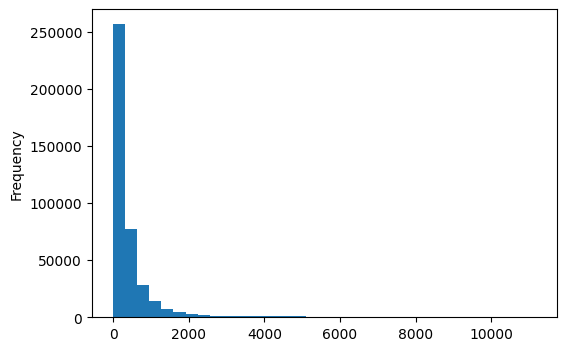

In [ ]:
print("Mean comment length: ", train_df['length'].mean())
print("Min comment length: ", train_df['length'].min())
print("Max comment length: ", train_df['length'].max())
plt.figure(figsize=(6,4))
train_df.length.plot.hist(bins=35)

The vast majority of messages in the dataset have lengths below 500 symbols.

Workaround: Loading previously saved clearned dataset:

---



In [ ]:
file_name = FILE_PATH + 'clearned_full_train_df.csv'

In [ ]:
train_df = pd.read_csv(file_name, sep='\t', index_col=0)
train_df.head()

,comment_text,toxic,lang,length
0,sugestão rfa com todo respeito prefiro não ret...,0,pt,555
1,sui sûr que est pa vrai,0,fr,37
2,одна остающаяся проблема blp привет спасибо ус...,0,ru,186
3,mudança significativa proponho fazer alteraçõ ...,0,pt,271
4,verdad alguien debería agregar una sección sob...,0,es,113


In [ ]:
val_df = pd.read_csv(FILE_PATH + '/validation.csv')
val_df['comment_text'].fillna("unknown", inplace=True)
val_df["comment_text"] = val_df["comment_text"].apply(clean_text)
val_df.head()

,id,comment_text,lang,toxic
0,0,est usuario siquiera llega rango herej por tan...,es,0
1,1,testo questa voce pare esser scopiazzato diret...,it,0
2,2,vale sólo expongo pasado todo tiempo pasado fu...,es,1
3,3,maddenin alt başlığı olarak uluslararası ilişk...,tr,0
4,4,belçika nın şehirlerinin yanında ilç beldeleri...,tr,0


Clearning from NaN rows:

In [ ]:
train_df['comment_text'].isna().sum()

213

In [ ]:
train_df=train_df.dropna(axis=0)

!!!!!!!!! No need to run if clearned dataframe provided

Preprocessing the dataset (lowercase, clearning from tags, punctuation signs, stopwords, numbers, etc.) :

In [ ]:
#clean the text first
train_df['comment_text'].fillna("unknown", inplace=True)
train_df["comment_text"] = train_df["comment_text"].apply(clean_text)

Saving the cleared dataframe:

In [ ]:
train_df.to_csv(file_name, sep='\t')

#### ------------ End of workaround ------------

Initially, there was an idea to process different languages independently but later I understood that it is not the case.

In [ ]:
eng_comments = train_df[train_df['lang']=='en']

In [ ]:
eng_comments

,comment_text,toxic,lang,length
14,link brookwood cemeteri ad link mini site site...,0,en,720
17,luv fuck cocain bitch,1,en,29
29,bless algeria stink racism hate spanglej expla...,0,en,740
33,exampl dynasti end kings—tutankhamun ay horemh...,0,en,510
38,factual low educ standard high level crime soc...,0,en,174
...,...,...,...,...
399969,revert recent offici countri origin info infob...,0,en,580
399987,oba chandler think articl reach level statu qu...,0,en,237
399990,revert biscuit articl,0,en,39
399991,wikipedia extend imag syntax,0,en,32


In [ ]:
train_df[train_df['lang']=='ru']

,comment_text,toxic,lang,length
2,одна остающаяся проблема blp привет спасибо ус...,0,ru,186
35,жесткий сигмоидоскоп обычно имеет диаметр мене...,0,ru,222
36,хватит возвращаться когда собственном названии...,0,ru,633
47,это нонсенс конечно даже сегодня орадя искусст...,0,ru,164
56,джон холмс пенис джона холмса был дюймов что е...,1,ru,120
...,...,...,...,...
399950,переместил список сюда добавил тег так почему ...,0,ru,71
399967,недавно заново создали статью «джош ханер» кот...,0,ru,239
399968,давайте держать это talk книги хроник тогда ка...,0,ru,79
399970,ассирийская статья почему это изменил,0,ru,42


In [ ]:
get_corpus_statistics(eng_comments['comment_text'])

Size of vocabulary:  85413
Most 20 common words are:


{'articl': 25885,
 'page': 19327,
 'wikipedia': 15815,
 'edit': 13794,
 'talk': 12089,
 'like': 11012,
 'delet': 8702,
 'sourc': 8574,
 'thank': 7892,
 'think': 7817,
 'know': 7230,
 'us': 6870,
 'time': 6754,
 'peopl': 6609,
 'fuck': 6468,
 'block': 5841,
 'need': 5722,
 'user': 5694,
 'remov': 5335,
 'want': 5332}

### Baseline: Tf-Idf + LogReg

Creating a pipeline for the first model (Logistic Regression on the TF-IDF vectors):

In [ ]:
#vectorization of the model
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1)

pipeline = Pipeline([
    ('tfidf', vec),
    ('logreg', LogisticRegression(penalty='elasticnet')),
])

parameters = {
    'tfidf__max_features': [None, 1000, 5000, 50000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # unigrams or unigrams + bigrams
    'logreg__penalty' : ['l1', 'l2'],
    'logreg__C' : np.logspace(-4, 4, 20),
    'logreg__solver' : ['liblinear'],
}

For hyperparameters tuning I am going to use RandomizedSearch over Stratified K-Fold cross-validation:

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(pipeline, parameters, n_jobs=-1, verbose=1,
                                   scoring=['roc_auc'],
                                   cv=cv, n_iter=10, refit='roc_auc')

In [ ]:
X_train, y_train = list(train_df["comment_text"]), list(train_df['toxic'])

In [ ]:
X_train[:4], y_train[:4]

(['sugestão rfa com todo respeito prefiro não retirá ainda embora reconheça que certament não estou nem perto bom começo gostaria deixá execução por pelo meno hora para nada mai atrair uma boa quantidad feedback comunidad agora tornar uma situação snow estarei mai que disposto retirar mai cedo ma part motivo pelo qual estou fazendo isso agora reunir algum feedback honesto comunidad sobr ond estou ond preciso melhorar não aprovado com êxito saudaçõ',
  'sui sûr que est pa vrai',
  'одна остающаяся проблема blp привет спасибо устранение проблем blp статье энн фэйрбэрн есть еще одна последняя редакция которая должна быть удалена противном случае спасибо',
  'mudança significativa proponho fazer alteraçõ significativa página todo parágrafo sencond problemático sendo errado algun aspecto muito geral alguma da part interessada tiver problema para fazer alteraçõ substanciai publiqu aqui'],
 [0, 0, 0, 0])

In [ ]:
%%time

random_search.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 2min 3s, sys: 14.7 s, total: 2min 18s
Wall time: 46min 18s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(ngram_range=(1,
                                                                           2),
                                                              smooth_idf=1,
                                                              strip_accents='unicode',
                                                              sublinear_tf=1,
                                                              tokenizer=<function tokenize at 0x7f6314dd2050>,
                                                              use_idf=1)),
                                             ('logreg',
                                              LogisticRegression(penalty='elasticnet'))]),
                   n_jobs=-1,
                   param_distributions={'logreg_...
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'logreg__penalty': ['l1', 'l2'],
                                        'logreg__solver': ['liblinear'],
                                        'tfidf__max_features': [None, 1000,
                                                                5000, 50000],
                                        'tfidf__ngram_range': [(1, 1), (1, 2)]},
                   refit='roc_auc', scoring=['roc_auc'], verbose=1)

In [ ]:
pd.DataFrame(random_search.cv_results_).sort_values('mean_test_roc_auc', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfidf__ngram_range,param_tfidf__max_features,param_logreg__solver,param_logreg__penalty,param_logreg__C,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
6,139.988982,9.159617,14.155540,2.724636,"(1, 2)",50000,liblinear,l2,4.281332,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.949423,0.947687,0.947926,0.946741,0.948997,0.948154,0.000958,1
3,176.003647,6.876163,17.929437,4.624382,"(1, 2)",None,liblinear,l1,1438.449888,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.943692,0.943539,0.942660,0.942881,0.941830,0.942920,0.000669,2
5,128.758103,3.728296,13.186361,2.060364,"(1, 2)",50000,liblinear,l1,4.281332,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.941626,0.939976,0.939707,0.939212,0.940208,0.940146,0.000811,3
7,50.619883,2.106230,10.869474,1.452512,"(1, 1)",None,liblinear,l1,0.233572,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.929365,0.928223,0.927695,0.929016,0.930630,0.928986,0.001010,4
1,40.858913,4.091612,8.272539,0.539231,"(1, 1)",5000,liblinear,l1,29.763514,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.913423,0.911422,0.914037,0.913869,0.914142,0.913378,0.001009,5
9,142.855709,22.206596,17.325753,4.414789,"(1, 2)",None,liblinear,l1,0.233572,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.913400,0.911689,0.912142,0.913302,0.915300,0.913167,0.001254,6
0,43.924895,5.511663,8.278011,0.508290,"(1, 1)",None,liblinear,l1,0.088587,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.898431,0.896155,0.895825,0.897370,0.901191,0.897794,0.001933,7
2,37.048547,0.278849,7.537672,0.431278,"(1, 1)",1000,liblinear,l1,78.475997,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.851592,0.850010,0.854154,0.852252,0.854253,0.852452,0.001605,8
4,116.890965,1.774270,11.457043,0.413765,"(1, 2)",1000,liblinear,l2,0.233572,"{'tfidf__ngram_range': (1, 2), 'tfidf__max_fea...",0.845332,0.845378,0.845089,0.850055,0.849518,0.847075,0.002223,9
8,39.366769,2.695957,7.614761,0.909234,"(1, 1)",1000,liblinear,l2,0.004833,"{'tfidf__ngram_range': (1, 1), 'tfidf__max_fea...",0.828096,0.825816,0.827812,0.828864,0.829238,0.827965,0.001191,10


In [ ]:
logreg_model = random_search.best_estimator_

Saving the model:

In [ ]:
filename = 'toxicity_log_reg.sav'

In [ ]:
save_sklearn_model(random_search.best_estimator_, filename)

#### ----- Workaround (loading pre-trained model) -----

In [ ]:
logreg_model = load_sklearn_model(filename)

In [ ]:
type(logreg_model)

sklearn.pipeline.Pipeline

------ End of workaround -----

Validating the performance of the model using AUC score:

In [ ]:
val_df = pd.read_csv(FILE_PATH + '/validation.csv')
val_df['comment_text'].fillna("unknown", inplace=True)
val_df["comment_text"] = val_df["comment_text"].apply(clean_text)

#score the validation dataset
y_valid = val_df['toxic']
y_pred_valid = logreg_model.predict_proba(val_df["comment_text"])
# print('Testing accuracy %s' % accuracy_score(y_valid, y_pred_valid))
# print('Testing F1 score: {}'.format(f1_score(y_valid, y_pred_valid, average='weighted')))
print('Validation AUC score %s' % roc_auc_score(y_valid, y_pred_valid[:, 1]))

del val_df, y_valid, y_pred_valid; gc.collect()

Validation AUC score 0.8581466536969654


18

In [ ]:
test_df = pd.read_csv(FILE_PATH + '/test.csv')
test_labels_df = pd.read_csv(FILE_PATH + '/test_labels.csv')
test_df["comment_text"] = test_df["content"].apply(clean_text)
test_with_labels = pd.concat([test_df, test_labels_df], axis=1)

y_test = test_with_labels['toxic']
y_pred_test = logreg_model.predict_proba(test_with_labels["comment_text"])
print('Testing AUC score %s' % roc_auc_score(y_test, y_pred_test[:, 1]))


# del test_df, y_pred_test; gc.collect()

Testing AUC score 0.8399376213349269


We have rather good number of AUC = 0.85 for the baseline model. Let's look if I can improve it with other models.

In [ ]:
del test_df, y_pred_test; gc.collect()

11

###Word2Vec

At this step I am going to train Word2Vec embeddings using the given corpus, calculate message embeddings, and use them as inputs for LogReg or another classification algorithm.

In [ ]:
import gensim
import nltk
from nltk import word_tokenize
import gensim.downloader as api

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
comments = list(train_df['comment_text'])

In [ ]:
comments[:25]

['sugestão rfa com todo respeito prefiro não retirá ainda embora reconheça que certament não estou nem perto bom começo gostaria deixá execução por pelo meno hora para nada mai atrair uma boa quantidad feedback comunidad agora tornar uma situação snow estarei mai que disposto retirar mai cedo ma part motivo pelo qual estou fazendo isso agora reunir algum feedback honesto comunidad sobr ond estou ond preciso melhorar não aprovado com êxito saudaçõ',
 'sui sûr que est pa vrai',
 'одна остающаяся проблема blp привет спасибо устранение проблем blp статье энн фэйрбэрн есть еще одна последняя редакция которая должна быть удалена противном случае спасибо',
 'mudança significativa proponho fazer alteraçõ significativa página todo parágrafo sencond problemático sendo errado algun aspecto muito geral alguma da part interessada tiver problema para fazer alteraçõ substanciai publiqu aqui',
 'verdad alguien debería agregar una sección sobr esto desafortunadament primero que pienso',
 'kara şövaly d

In [ ]:
tokenized_comments = [tokenize(cmt) for cmt in comments]

In [ ]:
tokenized_comments[:1]

Define Word2Vec hypers and train word embeddings:

In [ ]:
W2V_WINDOW = 5
W2V_EPOCH = 100
W2V_MIN_COUNT = 5
VECTOR_SIZE = 300

w2v_model = gensim.models.word2vec.Word2Vec(tokenized_comments, vector_size=VECTOR_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT).wv

Checking W2V ability to catch similarity between words:

In [ ]:
w2v_model.most_similar('tower')

[('bird', 0.8744868636131287),
 ('forest', 0.8576965928077698),
 ('ocean', 0.8544754385948181),
 ('beauti', 0.849450409412384),
 ('spring', 0.848310112953186),
 ('summer', 0.8458609580993652),
 ('underground', 0.845210611820221),
 ('glass', 0.8429901599884033),
 ('deep', 0.8368033766746521),
 ('squar', 0.8326097130775452)]

In [ ]:
w2v_model.most_similar('журнал')

[('издатель', 0.9294717311859131),
 ('трек', 0.9291907548904419),
 ('отчет', 0.9257216453552246),
 ('издании', 0.9246910810470581),
 ('журнала', 0.9240784049034119),
 ('текущий', 0.9237781167030334),
 ('стандартный', 0.9189480543136597),
 ('журнале', 0.9128798842430115),
 ('новый', 0.9124190807342529),
 ('редирект', 0.9095813632011414)]

Introducing special tags into W2V model:

In [ ]:
w2v_model["<unk>"] = np.random.rand(300)
w2v_model["<pad>"] = np.random.rand(300)

In [ ]:
w2v_model.get_index("<pad>")

164978

In [ ]:
w2v = w2v_model.vectors

In [ ]:
w2v_map = {
    word:idx
    for idx,word in enumerate(w2v_model.key_to_index, start=2)
}

Changing values for special tokens:

In [ ]:
w2v_map['<pad>'] = 1
w2v_map['<unk>'] = 0

I would like to restore the order of word embeddings according to the order of the obtained vocabulary. For this, I simply shift the numpy array with np.roll() function, which moves the two last values to the beginning of the array:

In [ ]:
w2v = np.roll(w2v, 2, axis=0)

#### Visualizing embedding space

As an optional exercise, I am going to visualize W2V embeddings space. For this, I will choose the first 5000 most common words:

In [ ]:
words = w2v_model.index_to_key[:5000]
word_vectors = w2v_model.vectors[[w2v_model.key_to_index[word] for word in words]]

In [ ]:
word_vectors.shape

(5000, 300)

Plotting the interactive plot of 2D projection of W2V space:

In [ ]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()

    if isinstance(color, str):
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show:
        pl.show(fig)
    return fig

In [ ]:
from sklearn.manifold import TSNE

def get_tsne_projection(word_vectors):
    tsne = TSNE(n_components=2)
    return tsne.fit_transform(word_vectors)

In [ ]:
word_tsne = get_tsne_projection(word_vectors)
draw_vectors(word_tsne[:, 0], word_tsne[:, 1], color='green', token=words)

Figure(id='1113', ...)

On the TSNE projection of the vector space, we can see distinct language clusters. If zoom the plot and check close points (which represent words) we can notice that they are grouped in smaller clusters by their meaning.

####Texts embeddings

Using the following function I have also obtained the array of texts embeddings which are simply the means of the vectors of all the words they contain.

In [ ]:
def get_phrase_embedding(model, phrase):
    tokenized = word_tokenize(phrase)
    if len(tokenized) > 0:
        vector = model.get_mean_vector(tokenized)
        return vector
    return np.zeros([model.vector_size], dtype='float32')

In [ ]:
text_vectors = np.array([get_phrase_embedding(w2v_model, text) for text in comments])

In [ ]:
X_train_w2v, y_train = text_vectors, list(train_df['toxic'])

In [ ]:
len(X_train_w2v), len(y_train)

(399787, 399787)

### Word2Vec + LogReg

Defining the model (logistic regression) and parameter space:

In [ ]:
lr_model = LogisticRegression(penalty='elasticnet')

parameters = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear'],
}

Hyperparameters tuning through cross validation:

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr_w2v_random_search = RandomizedSearchCV(lr_model, parameters, n_jobs=-1, verbose=1,
                                   scoring=['roc_auc'],
                                   cv=cv, n_iter=10, refit='roc_auc')

In [ ]:
%%time

lr_w2v_random_search.fit(X_train_w2v, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 23min 40s, sys: 4.74 s, total: 23min 44s
Wall time: 55min 59s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LogisticRegression(penalty='elasticnet'),
                   n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear']},
                   refit='roc_auc', scoring=['roc_auc'], verbose=1)

Results of randomized search:

In [ ]:
pd.DataFrame(lr_w2v_random_search.cv_results_).sort_values('mean_test_roc_auc', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_solver,param_penalty,param_C,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
1,1727.363318,113.165698,0.134582,0.003278,liblinear,l1,11.288379,"{'solver': 'liblinear', 'penalty': 'l1', 'C': ...",0.923298,0.926835,0.924427,0.926500,0.923664,0.924945,0.001457,1
5,908.493805,22.638349,0.207662,0.003777,liblinear,l1,1.623777,"{'solver': 'liblinear', 'penalty': 'l1', 'C': ...",0.922687,0.926100,0.923746,0.926413,0.922944,0.924378,0.001576,2
6,99.353361,3.437429,0.213787,0.008832,liblinear,l2,4.281332,"{'solver': 'liblinear', 'penalty': 'l2', 'C': ...",0.921983,0.925752,0.923573,0.926114,0.922538,0.923992,0.001669,3
9,309.742598,56.394105,0.165161,0.036676,liblinear,l1,0.615848,"{'solver': 'liblinear', 'penalty': 'l1', 'C': ...",0.921597,0.925197,0.922912,0.925709,0.921968,0.923477,0.001677,4
3,74.495749,4.118922,0.206960,0.005563,liblinear,l2,1.623777,"{'solver': 'liblinear', 'penalty': 'l2', 'C': ...",0.921025,0.924968,0.922915,0.925420,0.921720,0.923210,0.001736,5
0,53.567379,5.002586,0.209995,0.002984,liblinear,l1,0.033598,"{'solver': 'liblinear', 'penalty': 'l1', 'C': ...",0.912329,0.916090,0.914268,0.916208,0.912468,0.914273,0.001678,6
2,29.127729,1.331236,0.206652,0.006648,liblinear,l1,0.012743,"{'solver': 'liblinear', 'penalty': 'l1', 'C': ...",0.903969,0.907066,0.905373,0.907343,0.904025,0.905555,0.001440,7
7,18.913650,0.954250,0.208424,0.002494,liblinear,l1,0.004833,"{'solver': 'liblinear', 'penalty': 'l1', 'C': ...",0.893256,0.895333,0.893720,0.896617,0.893905,0.894566,0.001238,8
8,12.206229,0.176760,0.243655,0.039955,liblinear,l2,0.0001,"{'solver': 'liblinear', 'penalty': 'l2', 'C': ...",0.837935,0.835384,0.836175,0.834228,0.833590,0.835462,0.001527,9
4,7.713330,0.301146,0.203791,0.050802,liblinear,l1,0.0001,"{'solver': 'liblinear', 'penalty': 'l1', 'C': ...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,10


In [ ]:
filename = 'toxicity_w2v_log_reg.sav'

In [ ]:
if not os.path.exists(MODEL_PATH+filename):
  save_sklearn_model(lr_w2v_random_search.best_estimator_, filename)

In [ ]:
rs_name = 'lr_w2v_random_search'
if rs_name in locals() or rs_name in globals():
  lr_w2v_model = lr_w2v_random_search.best_estimator_
else:
  lr_w2v_model = load_sklearn_model(filename)
  type(lr_w2v_model)

Validating the model:

In [ ]:
val_df = pd.read_csv(FILE_PATH + '/validation.csv')
val_df['comment_text'].fillna("unknown", inplace=True)
val_df["comment_text"] = val_df["comment_text"].apply(clean_text)

val_comments = list(val_df['comment_text'])
val_text_vectors = np.array([get_phrase_embedding(w2v_model, text) for text in val_comments])

X_val_w2v, y_val = val_text_vectors, val_df['toxic']

y_pred_valid = lr_w2v_model.predict_proba(X_val_w2v)
# print('Testing accuracy %s' % accuracy_score(y_valid, y_pred_valid))
# print('Testing F1 score: {}'.format(f1_score(y_valid, y_pred_valid, average='weighted')))
print('Validation AUC score %s' % roc_auc_score(y_val, y_pred_valid[:, 1]))

del val_df, y_val, y_pred_valid; gc.collect()

Validation AUC score 0.7577329442422933


8

The score seems not that exciting (worse than a baseline)

### Doc2Vec + LogReg

At this step I am going to train Doc2Vec model from gensim library, and use its vectors as an input for the classificator.

Tokenizing the data in Doc2Vec style and adding tags using TaggedDocument class:

In [ ]:
labels = list(train_df['toxic'])
tagged_data = [TaggedDocument(d, [labels[i]]) for i, d in enumerate(tokenized_comments)]
tagged_data[:2]

[TaggedDocument(words=['sugestão', 'rfa', 'com', 'todo', 'respeito', 'prefiro', 'não', 'retirá', 'ainda', 'embora', 'reconheça', 'que', 'certament', 'não', 'estou', 'nem', 'perto', 'bom', 'começo', 'gostaria', 'deixá', 'execução', 'por', 'pelo', 'meno', 'hora', 'para', 'nada', 'mai', 'atrair', 'uma', 'boa', 'quantidad', 'feedback', 'comunidad', 'agora', 'tornar', 'uma', 'situação', 'snow', 'estarei', 'mai', 'que', 'disposto', 'retirar', 'mai', 'cedo', 'ma', 'part', 'motivo', 'pelo', 'qual', 'estou', 'fazendo', 'isso', 'agora', 'reunir', 'algum', 'feedback', 'honesto', 'comunidad', 'sobr', 'ond', 'estou', 'ond', 'preciso', 'melhorar', 'não', 'aprovado', 'com', 'êxito', 'saudaçõ'], tags=[0]),
 TaggedDocument(words=['sui', 'sûr', 'que', 'est', 'pa', 'vrai'], tags=[0])]

Initialize the Doc2Vec model using previously tagged messages:

In [ ]:
d2v_model = Doc2Vec(tagged_data, vector_size = 300, window = 2, min_count = 5, epochs = 100)

'''
vector_size = Dimensionality of the feature vectors.
window = The maximum distance between the current and predicted word within a sentence.
min_count = Ignores all words with total frequency lower than this.
'''

'\nvector_size = Dimensionality of the feature vectors.\nwindow = The maximum distance between the current and predicted word within a sentence.\nmin_count = Ignores all words with total frequency lower than this.\n'

Saving the model:

In [ ]:
filename = 'doc2vec_model.sav'

In [ ]:
d2v_model = load_sklearn_model(filename)
type(d2v_model)

gensim.models.doc2vec.Doc2Vec

In [ ]:
if not os.path.exists(MODEL_PATH+filename):
  save_sklearn_model(d2v_model, filename)

Preparing validation data:

In [ ]:
val_comments = list(val_df['comment_text'])
val_labels = list(val_df['toxic'])
val_tokenized_comments = [tokenize(cmt) for cmt in val_comments]
test_tagged = [TaggedDocument(d, [val_labels[i]]) for i, d in enumerate(val_tokenized_comments)]

In [ ]:
tagged_data[:1]

[TaggedDocument(words=['sugestão', 'rfa', 'com', 'todo', 'respeito', 'prefiro', 'não', 'retirá', 'ainda', 'embora', 'reconheça', 'que', 'certament', 'não', 'estou', 'nem', 'perto', 'bom', 'começo', 'gostaria', 'deixá', 'execução', 'por', 'pelo', 'meno', 'hora', 'para', 'nada', 'mai', 'atrair', 'uma', 'boa', 'quantidad', 'feedback', 'comunidad', 'agora', 'tornar', 'uma', 'situação', 'snow', 'estarei', 'mai', 'que', 'disposto', 'retirar', 'mai', 'cedo', 'ma', 'part', 'motivo', 'pelo', 'qual', 'estou', 'fazendo', 'isso', 'agora', 'reunir', 'algum', 'feedback', 'honesto', 'comunidad', 'sobr', 'ond', 'estou', 'ond', 'preciso', 'melhorar', 'não', 'aprovado', 'com', 'êxito', 'saudaçõ'], tags=[0])]

In [ ]:
def vec_for_learning(model, tagged_docs):
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, )) for doc in tagged_docs])
    return targets, regressors

In [ ]:
y_train, X_train = vec_for_learning(d2v_model, tagged_data[:100000])

In [ ]:
y_train[:10]

(0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

In [ ]:
len(test_tagged)

8000

Train the LogReg model using Doc2Vec vectors:

In [ ]:
#y_train, X_train = vec_for_learning(d2v_model, tagged_data)
y_test, X_test = vec_for_learning(d2v_model, test_tagged)
logreg = LogisticRegression(penalty='l1', solver='liblinear', n_jobs=1, C=10)

y_pred, y_probs = classifier_f(logreg, X_train, y_train, X_test)

#logreg.fit(X_train, y_train)
#y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Validation accuracy %s' % accuracy_score(y_test, y_pred))
print('Validation AUC score %s' % roc_auc_score(y_test, y_probs[:, 1]))

Validation accuracy 0.739
Validation AUC score 0.7481820801959866


Again accuracy and AUC score of this method aren't good enought. Probably I need to finetune the model, or train it on more data (here I use just about 30% of the whole set in sake of speeding up the training process).

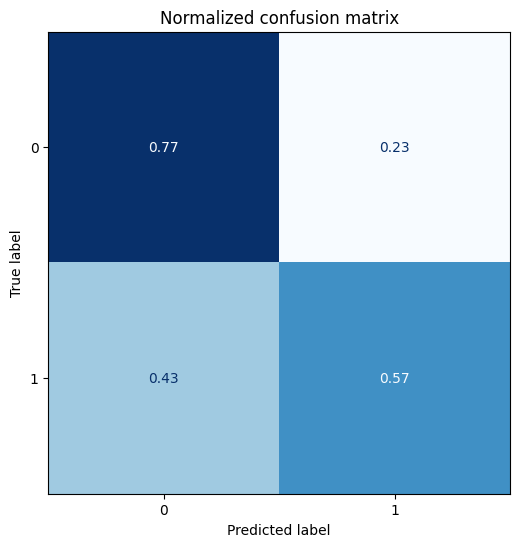

In [ ]:
plot_labels = [0,1]
plot_confusion_matrix(y_pred, y_test, plot_labels)

In [ ]:
y_pred[:10], y_test[:10]

(array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0]), (0, 0, 1, 0, 0, 0, 0, 0, 0, 0))

### Doc2Vec + XGBC

Below I am trying another classification algorithm (XGBoost Classifier) on the previously created Doc2Vec embeddings.

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgbc = XGBClassifier(eta=0.2, max_depth=17, n_estimators= 300, scale_pos_weight=101, subsample=0.9, colsample_bytree=0.6)
y_pred, y_probs = classifier_f(xgbc, X_train, y_train, X_test)

print('Validation accuracy %s' % accuracy_score(y_test, y_pred))
print('Validation AUC score %s' % roc_auc_score(y_test, y_probs[:, 1]))

Validation accuracy 0.856125
Validation AUC score 0.7482968860707809


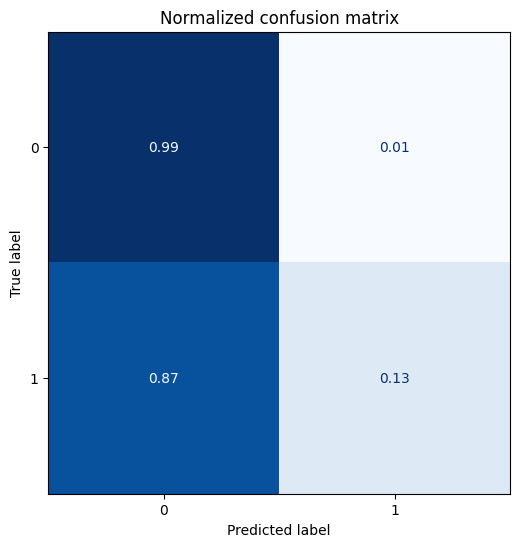

In [ ]:
plot_labels = [0,1]
plot_confusion_matrix(y_pred, y_test, plot_labels)

Even though we got better accuracy, recall for class 1 is quite low, hence AUC is low too.

#### XGBC fine tuning

Probably we can improve score by tuning hyperparameters? Let's try:

In [ ]:
xgbc_model = XGBClassifier()

xgbc_params = {
    'eta':[0.1,0.2],
    "n_estimators":[150,200,250,300],
    "max_depth":[6,8,10,12,15],
    'scale_pos_weight':[50, 100, 150]
}

In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
xgbc_random_search = RandomizedSearchCV(xgbc_model, xgbc_params, n_jobs=-1, verbose=1,
                                   scoring=['roc_auc'],
                                   cv=cv, n_iter=5, refit='roc_auc')

In [ ]:
%%time

xgbc_random_search.fit(X_train, y_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU times: user 53min 20s, sys: 9.48 s, total: 53min 30s
Wall time: 3h 30min 25s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importan...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'eta': [0.1, 0.2],
                                        'max_depth': [6, 8, 10, 12, 15],
                                        'n_estimators': [150, 200, 250, 300],
                                        'scale_pos_weight': [50, 100, 150]},
                   refit='roc_auc', scoring=['roc_auc'], verbose=1)

In [ ]:
filename = 'toxicity_d2v_xgbc.sav'

In [ ]:
if not os.path.exists(MODEL_PATH+filename):
  save_sklearn_model(xgbc_random_search.best_estimator_, filename)

In [ ]:
rs_name = 'xgbc_random_search'
if rs_name in locals() or rs_name in globals():
  xgbc_best = xgbc_random_search.best_estimator_
else:
  xgbc_best = load_sklearn_model(filename)
  type(xgbc_best)

In [ ]:
y_test_proba = xgbc_best.predict_proba(X_test)

print('Validation AUC score %s' % roc_auc_score(y_test, y_test_proba[:, 1]))

Validation AUC score 0.7469253401544356


###DistilBERT + LogReg

At the next step I am going to use pretrained DistilBERT model in order to get contextual embeddings and then use these embeddings as inputs to the classificator (LogReg).

First we need to install transformers library:

In [ ]:
! pip install -U transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.9 MB/s eta 0:00:00


In [ ]:
! pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 7.5 MB/s eta 0:00:00


In [ ]:
import torch
import transformers as ppb
from sklearn.model_selection import cross_val_score
from torch.utils.data import TensorDataset, random_split, DataLoader, Dataset

For performance reasons, we'll only use 2,000 sentences from the dataset

In [ ]:
batch_1 = train_df[:10000]
batch_1['toxic'].value_counts()

0    9019
1     981
Name: toxic, dtype: int64

In order to make the dataset more balanced I use an augmenter from nlpaug library which oversample the minority class to some extent:

In [ ]:
import nlpaug.augmenter.word as nlpaw


def augment_sentence(sentence, aug, num_threads):
    """""""""
    Constructs a new sentence via text augmentation.

    Input:
        - sentence:     A string of text
        - aug:          An augmentation object defined by the nlpaug library
        - num_threads:  Integer controlling the number of threads to use if
                        augmenting text via CPU
    Output:
        - A string of text that been augmented
    """""""""
    return aug.augment(sentence, num_thread=num_threads)



def augment_text(df, aug, num_threads, num_times):
    """""""""
    Takes a pandas DataFrame and augments its text data.

    Input:
        - df:            A pandas DataFrame containing the columns:
                                - 'comment_text' containing strings of text to augment.
                                - 'isToxic' binary target variable containing 0's and 1's.
        - aug:           Augmentation object defined by the nlpaug library.
        - num_threads:   Integer controlling number of threads to use if augmenting
                         text via CPU
        - num_times:     Integer representing the number of times to augment text.
    Output:
        - df:            Copy of the same pandas DataFrame with augmented data
                         appended to it and with rows randomly shuffled.
    """""""""

    # Get rows of data to augment
    to_augment = df[df['toxic']==1]
    to_augmentX = to_augment['comment_text']
    to_augmentY = np.ones(len(to_augmentX.index) * num_times, dtype=np.int8)

    # Build up dictionary containing augmented data
    aug_dict = {'comment_text':[], 'toxic':to_augmentY}
    for i in tqdm(range(num_times)):
        augX = [augment_sentence(x, aug, num_threads) for x in to_augmentX]
        aug_dict['comment_text'].extend(augX)

    # Build DataFrame containing augmented data
    aug_df = pd.DataFrame.from_dict(aug_dict)

    return df.append(aug_df, ignore_index=True).sample(frac=1, random_state=42)



# Define nlpaug augmentation object
aug10p = nlpaw.ContextualWordEmbsAug(model_path='bert-base-multilingual-cased', aug_min=1, aug_p=0.1, action="substitute")

# Upsample minority class ('isToxic' == 1) to create a roughly 50-50 class distribution
balanced_df = augment_text(batch_1, aug10p, num_threads=8, num_times=3)

  0%|          | 0/3 [00:00<?, ?it/s]

Clean new syntetic lines:

In [ ]:
balanced_df["comment_text"] = balanced_df["comment_text"].apply(clean_text)

In [ ]:
balanced_df.toxic.value_counts()

0    9019
1    3924
Name: toxic, dtype: int64

After oversampling we have 1:2 proportion between classes. This is much better than initial 1:10.

Saveing balanced dataset to disk:

In [ ]:
file_name = FILE_PATH + 'balanced_dataset_13000.csv'

In [ ]:
balanced_df.to_csv(file_name, sep='\t')

Loading balanced dataset:

In [ ]:
balanced_df = pd.read_csv(file_name, sep='\t', usecols=needed_cols)

In [ ]:
balanced_df=balanced_df.dropna(axis=0)
balanced_df.shape

(12929, 2)

In [ ]:
balanced_df.head()

,comment_text,toxic
0,peni,1
1,fair foutr pouvez dire raison valabl pour votr...,1
2,suck differ reason let english dai ago slept b...,1
3,agr word,0
4,etiketi kaldırdım neden ekledin temsil edildiğ...,0


sss

Importing pre-trained DistilBERT model and tokenizer:

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-multilingual-cased')

Instantiating the DistilBERT model and tokenizer:

In [ ]:
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
db_model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Experiments with tokenizer:

In [ ]:
encoded_text = tokenizer('Tokenizing text is a core task in NLP')
encoded_text

{'input_ids': [101, 11469, 11062, 39949, 15541, 10124, 169, 27362, 37758, 10106, 81130, 11127, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]',
 'To',
 '##ken',
 '##izing',
 'text',
 'is',
 'a',
 'core',
 'task',
 'in',
 'NL',
 '##P',
 '[SEP]']

In [ ]:
print('The vocabulary size is:', tokenizer.vocab_size)

The vocabulary size is: 119547


In [ ]:
text = "this is a test"
sample_inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {sample_inputs['input_ids'].size()}\n"
      f"Tokenized text: {tokenizer.convert_ids_to_tokens(sample_inputs['input_ids'][0])}")

Input tensor shape: torch.Size([1, 6])
Tokenized text: ['[CLS]', 'this', 'is', 'a', 'test', '[SEP]']


In [ ]:
inputs = {k:v.to(device) for k,v in sample_inputs.items()}

with torch.no_grad():
    outputs = db_model(**inputs)
    print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[ 0.0529, -0.0609,  0.2082,  ...,  0.4475,  0.1659,  0.0650],
         [-0.1337, -0.4254,  0.3473,  ...,  0.4505,  0.0802,  0.0201],
         [-0.2687, -0.2589,  0.4270,  ...,  0.6192,  0.1775,  0.2215],
         [ 0.1024, -0.2293,  0.3213,  ...,  0.6366,  0.4073, -0.1296],
         [-0.1434, -0.1328,  0.2595,  ...,  0.6412,  0.2903,  0.2461],
         [ 0.1074, -0.1401,  0.3499,  ...,  0.4223,  0.1235,  0.1860]]],
       device='cuda:0'), hidden_states=None, attentions=None)


Sending the model to GPU (if available):

In [ ]:
db_model.to(device)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

Tokenizing the whole dataset:

In [ ]:
tokenized = balanced_df['comment_text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True)))

And defining labels:

In [ ]:
labels = balanced_df['toxic']

In [ ]:
tokenized.shape, labels.shape

((12929,), (12929,))

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
padded.shape

(12929, 512)

**Masking** <br>
If we directly send `padded` to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. That's what attention_mask is:

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(12929, 512)

In [ ]:
del tokenized; gc.collect()

0

#### Defining Dataset and Dataloader:

With the corpus work out of the way, we now proceed to prepare our data for analysis in PyTorch. The code below creates a TensorDataset comprised of our features, attention masks, and our labels. It then proceeds to spit the data sets into train and validation sets.

In [ ]:
# prepare tensor data sets
def prepare_dataset(padded_tokens, attention_masks, target):
    # prepare target into np array
    target = np.array(target.values, dtype=np.int64).reshape(-1, 1)
    # create tensor data sets
    tensor_df = TensorDataset(torch.from_numpy(padded_tokens), torch.from_numpy(attention_masks), torch.from_numpy(target))

    return tensor_df

In [ ]:
train_dataset = prepare_dataset(padded, attention_mask, labels)

Since my corpus is imbalanced, I produce weighted samplers to help balance the distribution of data as it is fed outside of my data loaders.

In [ ]:
# helper function to count target distribution inside tensor data sets
def target_count(tensor_dataset):
    # set empty count containers
    count0 = 0
    count1 = 0
    # set total container to turn into torch tensor
    total = []
    # for every item in the tensor data set
    for i in tensor_dataset:
        # if the target is equal to 0
        if i[2].item() == 0:
            count0 += 1
        # if the target is equal to 1
        elif i[2].item() == 1:
            count1 += 1
    total.append(count0)
    total.append(count1)
    return torch.tensor(total)


# prepare weighted sampling for imbalanced classification
def create_sampler(target_tensor, tensor_dataset):
    # generate class distributions [x, y]
    class_sample_count = target_count(tensor_dataset)
    # weight
    weight = 1. / class_sample_count.float()
    # produce weights for each observation in the data set
    samples_weight = torch.tensor([weight[t[2]] for t in tensor_dataset])
    # prepare sampler
    sampler = torch.utils.data.WeightedRandomSampler(weights=samples_weight,
                                                     num_samples=len(samples_weight),
                                                     replacement=True)
    return sampler


# create samplers for just training
train_sampler = create_sampler(target_count(train_dataset), train_dataset)

Actually sampler doesn't give much improvement so in later versions I stopped using it.

In [ ]:
# create DataLoader
train_dataloader = DataLoader(train_dataset,
                              batch_size=8,
                              shuffle=False)

#sampler=train_sampler,

Let's see how the output of Dataloader looks like:

In [ ]:
next(iter(train_dataloader))

[tensor([[   101,  66558,  10116,  ...,      0,      0,      0],
         [   101,  45122,  12688,  ...,      0,      0,      0],
         [   101,  10198,  11263,  ...,      0,      0,      0],
         ...,
         [   101,  24542, 107602,  ...,      0,      0,      0],
         [   101,  17339,  58495,  ...,      0,      0,      0],
         [   101,  13868,  99038,  ...,      0,      0,      0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([[1],
         [1],
         [1],
         [0],
         [0],
         [1],
         [0],
         [1]])]

We can see three blocks of data: the first is tokenized sentences - every one of them starts and ends with special tokens <CLS> = 101 and <SEP> = 102, and padded to the maximum length with zeroes.

In [ ]:
def extract_hidden_states(batch):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    with torch.inference_mode():
        last_hidden_state = db_model(b_input_ids, b_input_mask).last_hidden_state

    return last_hidden_state[:, 0].cpu()

We now create an input tensor out of the padded token matrix, and send that to DistilBERT:

In [ ]:
%%time
last_hidden_states=[]

for batch in train_dataloader:
  last_hs = extract_hidden_states(batch)

  last_hidden_states.extend(last_hs)
  del last_hs; gc.collect()

CPU times: user 10min 52s, sys: 1.81 s, total: 10min 53s
Wall time: 10min 50s


After running this step, last_hidden_states holds the outputs of DistilBERT. It is a tuple with the shape (number of examples, max number of tokens in the sequence, number of hidden units in the DistilBERT model). We put to the output tensor only states related with the first token in every sentece (<CLS)>. It will be our embedding for the whole sentence (comment). So in our case output matrix will be 2d and will have following shape: (number of examples, number of hidden units in the DistilBERT model).

In [ ]:
lhs_tensor = torch.stack(last_hidden_states)
lhs_tensor.shape

torch.Size([12943, 768])

In [ ]:
del last_hidden_states; gc.collect()

0

In [ ]:
features = lhs_tensor
features.shape

torch.Size([12943, 768])

In [ ]:
np_features=features.numpy()
np_features.shape, labels.shape

((12943, 768), (12943,))

Doing train-test split out of features (sentence vectors) we got from DistilBERT:

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(np_features, labels, test_size=0.2, random_state=42)

In [ ]:
train_features.shape, train_labels.shape

((10354, 768), (10354,))

Let's see if we have distinct positional difference in the vector space between positive and negative classes:

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

pca = PCA(n_components=2)

x_scaled = MinMaxScaler().fit_transform(train_features)
x_2d = pca.fit_transform(x_scaled)
x_2d.shape

(10354, 2)

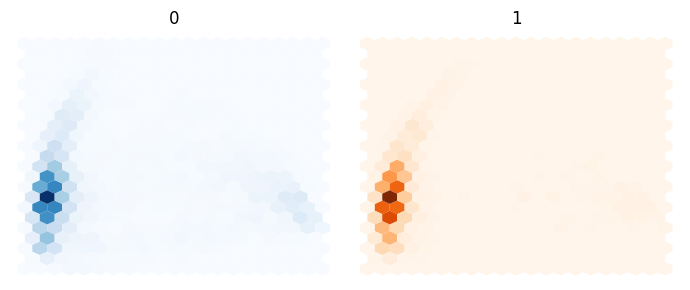

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax = ax.flatten()
cmaps = ["Blues", "Oranges"]
plot_labels = [0, 1]

for i, (label, cmap) in enumerate(zip(plot_labels, cmaps)):
    x_2d_sub = x_2d[train_labels == i]
    ax[i].hexbin(x_2d_sub[:, 0], x_2d_sub[:, 1], cmap=cmap, gridsize=20, linewidths=(0,))
    ax[i].set_title(label)
    ax[i].set_axis_off()

plt.tight_layout()
plt.show()

Seems that both classes take similar positions in the vector space.

Instantiating and training the LogReg classificator which will identify classes using sentences embeddings obtained in the previous step:

In [ ]:
lr_clf = LogisticRegression(solver='liblinear', penalty='l1', max_iter=3000)
lr_clf.fit(train_features, train_labels)

LogisticRegression(max_iter=3000, penalty='l1', solver='liblinear')

In [ ]:
lr_clf.score(test_features, test_labels)

0.8111239860950173

Validating the model:

In [ ]:
logreg = LogisticRegression(max_iter=3000)

y_pred, y_probs = classifier_f(logreg, train_features, train_labels, test_features)


from sklearn.metrics import accuracy_score, f1_score
print('Validation accuracy %s' % accuracy_score(test_labels, y_pred))
print('Validation AUC score %s' % roc_auc_score(test_labels, y_probs[:, 1]))

Validation accuracy 0.817303978370027
Validation AUC score 0.871758725573256


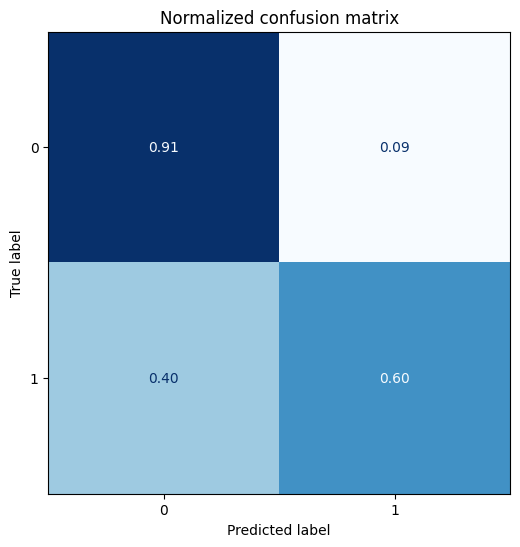

In [ ]:
plot_labels = [0, 1]
plot_confusion_matrix(y_pred, test_labels, plot_labels)

In [ ]:
y_pred[:10],np.array(test_labels[:10])

(array([0, 1, 1, 0, 1, 1, 0, 1, 0, 1]), array([0, 1, 1, 0, 1, 1, 0, 1, 0, 0]))

As we can see results are better then with previously used models.

In [ ]:
file_name = FILE_PATH + 'distilbert_features_13000.csv'

In [ ]:
distilbert_df = pd.DataFrame(np_features)
labels_df = pd.DataFrame(labels)
distilbert_df.shape, labels_df.shape

((12943, 768), (12943, 1))

In [ ]:
distilbert_df = pd.concat([distilbert_df,labels_df.reset_index(drop=True)], axis=1)
distilbert_df.shape

(12943, 769)

In [ ]:
distilbert_df.to_csv(file_name, sep='\t')

### Fine tuning DistilBERT

Last step in this submission is to finetune one of the models. I am going to try to create my own classificator based on the pretrained DistilBERT model and train it to classify toxicity using given training dataset.

First let's define some constants:

In [ ]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 1e-05
NUM_WORKERS = 2

I will use just a portion of the whole dataset for the sake of speeding up the training process:

In [ ]:
batch_2 = train_df[10000:40000]
batch_2['toxic'].value_counts()

0    27161
1     2839
Name: toxic, dtype: int64

Tokenizing the train batch:

In [ ]:
tokenized = batch_2['comment_text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True)))

In [ ]:
labels = batch_2['toxic']

In [ ]:
tokenized.shape, labels.shape

((12929,), (12929,))

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
padded.shape

(30000, 512)

#### Masking
If we directly send `padded` to the model, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. That's what attention_mask is:

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(30000, 512)

In [ ]:
del tokenized; gc.collect()

5932

Defining Dataset and Dataloader:

In [ ]:
train_dataset = prepare_dataset(padded, attention_mask, labels)

In [ ]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=TRAIN_BATCH_SIZE,
                              shuffle=False)


In [ ]:
len(train_dataloader)

1875

Creating neural binary classification model based on the pretrained DistilBERT:

In [ ]:
class DistilBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = ppb.DistilBertModel.from_pretrained("distilbert-base-multilingual-cased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

Instantiating the model and sending it to GPU:

In [ ]:
dbc_model = DistilBERTClass()
dbc_model.to(device)

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(i

Loss function (Binary Cross Enthropy with Logits):

In [ ]:
def loss_fn(outputs, targets):
  #print(outputs.shape, targets.shape)
  return torch.nn.BCEWithLogitsLoss()(outputs, targets)

Defining the optimizer ( Adam):

In [ ]:
optimizer = torch.optim.Adam(params = dbc_model.parameters(), lr=LEARNING_RATE)

Aux function to perform training process:

In [ ]:
def train(epoch):

    dbc_model.train()
    for _,data in tqdm(enumerate(train_dataloader, 0)):
        ids = data[0].to(device, dtype = torch.long)
        mask = data[1].to(device, dtype = torch.long)
        targets = data[2].to(device, dtype = torch.float)

        outputs = dbc_model(ids, mask)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%100==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        loss.backward()
        optimizer.step()

In [ ]:
next(iter(train_dataloader))[0].shape

torch.Size([16, 512])

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)

0it [00:00, ?it/s]

Epoch: 0, Loss:  0.6873781681060791
Epoch: 0, Loss:  0.33474522829055786
Epoch: 0, Loss:  0.22990038990974426
Epoch: 0, Loss:  0.206232950091362
Epoch: 0, Loss:  0.23829014599323273
Epoch: 0, Loss:  0.3573547303676605
Epoch: 0, Loss:  0.10454019904136658
Epoch: 0, Loss:  0.20958362519741058
Epoch: 0, Loss:  0.18106651306152344
Epoch: 0, Loss:  0.12088949978351593
Epoch: 0, Loss:  0.0707036629319191
Epoch: 0, Loss:  0.24887782335281372
Epoch: 0, Loss:  0.13374373316764832
Epoch: 0, Loss:  0.24838531017303467
Epoch: 0, Loss:  0.42278024554252625
Epoch: 0, Loss:  0.1563529372215271
Epoch: 0, Loss:  0.48402243852615356
Epoch: 0, Loss:  0.12045544385910034
Epoch: 0, Loss:  0.13914868235588074


0it [00:00, ?it/s]

Epoch: 1, Loss:  0.0915340930223465
Epoch: 1, Loss:  0.23600852489471436
Epoch: 1, Loss:  0.13964399695396423
Epoch: 1, Loss:  0.10987131297588348
Epoch: 1, Loss:  0.23683467507362366
Epoch: 1, Loss:  0.17810124158859253
Epoch: 1, Loss:  0.038863956928253174
Epoch: 1, Loss:  0.1876453012228012
Epoch: 1, Loss:  0.06918695569038391
Epoch: 1, Loss:  0.03592580556869507
Epoch: 1, Loss:  0.07142040878534317
Epoch: 1, Loss:  0.07798917591571808
Epoch: 1, Loss:  0.06073678657412529
Epoch: 1, Loss:  0.06972308456897736
Epoch: 1, Loss:  0.4719145894050598
Epoch: 1, Loss:  0.06786513328552246
Epoch: 1, Loss:  0.11548314243555069
Epoch: 1, Loss:  0.08898499608039856
Epoch: 1, Loss:  0.0276804119348526


Preparing evaluation batch, tokenizing and creating masks:

In [ ]:
test_batch = val_df[4000:6000]
test_batch['toxic'].value_counts()

0    1701
1     299
Name: toxic, dtype: int64

In [ ]:
test_tokenized = test_batch['comment_text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True)))

In [ ]:
test_labels = test_batch['toxic']

In [ ]:
max_len = 0
for i in test_tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

test_padded = np.array([i + [0]*(max_len-len(i)) for i in test_tokenized.values])
test_padded.shape

(2000, 419)

In [ ]:
test_attention_mask = np.where(test_padded != 0, 1, 0)
test_attention_mask.shape

(2000, 419)

In [ ]:
test_dataset = prepare_dataset(test_padded, test_attention_mask, test_labels)

In [ ]:
test_dataloader = DataLoader(test_dataset,
                              batch_size=8,
                              shuffle=False)
len(test_dataloader)

250

Function to get inference out of the model:

In [ ]:
all_test_pred = []

def test(model):
    model.eval()

    with torch.inference_mode():

        for _, data in tqdm(enumerate(test_dataloader, 0)):


          ids = data[0].to(device, dtype=torch.long)
          mask = data[1].to(device, dtype=torch.long)
          outputs = model(ids, mask)
          probas = torch.sigmoid(outputs)

          all_test_pred.append(probas)
    return probas

Collecting results from all batches:

In [ ]:
probas = test(dbc_model)

0it [00:00, ?it/s]

Concatinate them:

In [ ]:
all_test_pred = torch.cat(all_test_pred)

Formatting output data to the format that could be used in metrics calculations:

In [ ]:
test_probs = all_test_pred.reshape(1,-1).squeeze().cpu().numpy()
test_pred = test_probs.round().squeeze()

In [ ]:
test_probs.shape, test_pred.shape

((2000,), (2000,))

Calculate accuracy and AUC score:

In [ ]:
print('Validation accuracy %s' % accuracy_score(test_labels, test_pred))
print('Validation AUC score %s' % roc_auc_score(test_labels, test_probs))

Validation accuracy 0.8725
Validation AUC score 0.8413996095155516


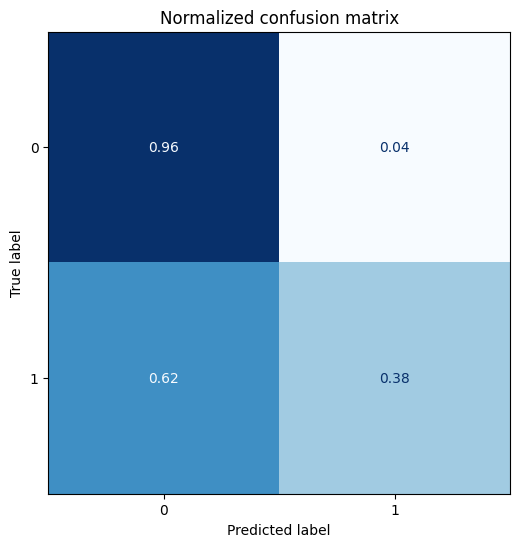

In [ ]:
plot_labels = [0, 1]
plot_confusion_matrix(test_pred, test_labels, plot_labels)

As we can see even though the model predicts the 0 class quite effectively, recall for the 1 class is still low so the overall AUC metric of the model is still not perfect.

In [ ]:
model_save(dbc_model, 'DistilBERT_classifier')

Saving model to: /content/drive/MyDrive/ds_data/toxicity_data/models/DistilBERT_classifier
